<a href="https://colab.research.google.com/github/Tam107/BDM/blob/main/Main_BDM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
# Install a newer version of matplotlib if needed
!pip install matplotlib==3.8.0

# Data processing
import pandas as pd
import numpy as np

# Train/test split and preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler  # Thay MinMaxScaler bằng StandardScaler

# Visualization
import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})
import matplotlib.pyplot as plt

# Neural network visualization
from tensorflow.keras.utils import plot_model
from IPython.display import Image

# Deep learning model
from tensorflow.keras.layers import Input, Dense, Reshape, Concatenate, Embedding, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

print("Completed")

# Print current directory to verify
!pwd

Completed
/content


# Entity Embedding Training

Cell 2: Tải và Kiểm Tra Dataset

In [46]:
# List of columns to keep from autos.csv
cols_to_keep = [
    'price',              # Target variable
    'brand',              # Categorical variable for embedding
    'model',              # Categorical variable for embedding
    'vehicleType',        # Categorical variable for embedding
    'fuelType',           # Categorical variable for embedding
    'gearbox',            # Categorical variable for dummy encoding
    'kilometer',          # Numeric variable
    'powerPS',            # Numeric variable
    'yearOfRegistration', # Numeric variable
    'monthOfRegistration',# Numeric variable
    'nrOfPictures',       # Numeric variable
    'postalCode',         # Now treated as categorical
    'dateCreated'         # To extract adYear
]

# Read data from autos.csv (adjust path as needed)
data = pd.read_csv('autos.csv', encoding='latin1', usecols=cols_to_keep)

# Show first 5 rows
print("First 5 rows of the dataset:")
print(data.head())

# Display dataset info
print("\nDataset Info:")
print(data.info())

First 5 rows of the dataset:
   price vehicleType  yearOfRegistration    gearbox  powerPS  model  \
0    480         NaN                1993    manuell        0   golf   
1  18300       coupe                2011    manuell      190    NaN   
2   9800         suv                2004  automatik      163  grand   
3   1500  kleinwagen                2001    manuell       75   golf   
4   3600  kleinwagen                2008    manuell       69  fabia   

   kilometer  monthOfRegistration fuelType       brand          dateCreated  \
0     150000                    0   benzin  volkswagen  2016-03-24 00:00:00   
1     125000                    5   diesel        audi  2016-03-24 00:00:00   
2     125000                    8   diesel        jeep  2016-03-14 00:00:00   
3     150000                    6   benzin  volkswagen  2016-03-17 00:00:00   
4      90000                    7   diesel       skoda  2016-03-31 00:00:00   

   nrOfPictures  postalCode  
0             0       70435  
1        

Cell 3: Tiền Xử Lý Dữ Liệu

In [47]:
# Extract year from dateCreated
data['dateCreated'] = pd.to_datetime(data['dateCreated'])
data['adYear'] = data['dateCreated'].dt.year
data = data.drop(columns=['dateCreated'])

# Define categorical and numerical columns
categorical_cols = ['brand', 'model', 'vehicleType', 'fuelType', 'postalCode', 'gearbox']
numerical_cols = ['kilometer', 'powerPS', 'yearOfRegistration', 'monthOfRegistration', 'nrOfPictures', 'adYear']

# Impute missing values: median for numeric, 'missing' for categorical
for col in numerical_cols:
    data[col] = data[col].fillna(data[col].median())
for col in categorical_cols:
    data[col] = data[col].fillna('missing').astype(str)

# Loại bỏ các mẫu có price = 0 hoặc nhỏ hơn 0
data = data[data['price'] > 0]

# Cap outliers using stricter percentiles for price and kilometer
for col in ['price', 'kilometer']:
    lower_bound = data[col].quantile(0.005)  # 0.5% percentile
    upper_bound = data[col].quantile(0.995)  # 99.5% percentile
    data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)

# Normalize numerical data using StandardScaler
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Normalize price separately
price_scaler = StandardScaler()
data['price'] = price_scaler.fit_transform(data[['price']])

# Display first 5 rows after preprocessing
print("\nFirst 5 rows after preprocessing:")
print(data.head())

# Dataset info after processing
print("\nDataset info after processing:")
print(data.info())

<ipython-input-47-276be2e170cf>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)
<ipython-input-47-276be2e170cf>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)



First 5 rows after preprocessing:
      price vehicleType  yearOfRegistration    gearbox   powerPS    model  \
0 -0.731488     missing           -0.139463    manuell -0.611603     golf   
1  1.736419       coupe            0.079770    manuell  0.385208  missing   
2  0.559247         suv           -0.005487  automatik  0.243556    grand   
3 -0.590228  kleinwagen           -0.042026    manuell -0.218125     golf   
4 -0.299397  kleinwagen            0.043231    manuell -0.249603    fabia   

   kilometer  monthOfRegistration fuelType       brand  nrOfPictures  \
0   0.610954            -1.572821   benzin  volkswagen           0.0   
1  -0.016609            -0.215844   diesel        audi           0.0   
2  -0.016609             0.598342   diesel        jeep           0.0   
3   0.610954             0.055551   benzin  volkswagen           0.0   
4  -0.895199             0.326947   diesel       skoda           0.0   

  postalCode    adYear  
0      70435  0.008985  
1      66954  0.008

Cell 4: Train-Test Split and Prepare Inputs

In [48]:
# Features and target
X = data.drop(['price'], axis=1).copy()
y = data['price']

# Split into train_val and test (80% train_val, 20% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split train_val into train and validation (80% train, 20% validation of train_val)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Check number of records
print(f'\nTraining set: {X_train.shape[0]} records with {X_train.shape[1]} columns.')
print(f'Validation set: {X_val.shape[0]} records with {X_val.shape[1]} columns.')
print(f'Test set: {X_test.shape[0]} records with {X_test.shape[1]} columns.')


Training set: 230880 records with 12 columns.
Validation set: 57720 records with 12 columns.
Test set: 72150 records with 12 columns.


Cell 5: Prepare Numerical Inputs and Build Model

In [49]:
# Encode categorical variables for embedding
cat_encoders = {}
embedding_dims = {}
for col in categorical_cols:
    unique_cat = np.unique(X_train[col])
    cat_encoders[col] = {val: idx for idx, val in enumerate(unique_cat)}
    X_train[col] = X_train[col].map(cat_encoders[col]).astype(np.int32)
    X_val[col] = X_val[col].map(cat_encoders[col]).fillna(0).astype(np.int32)
    X_test[col] = X_test[col].map(cat_encoders[col]).fillna(0).astype(np.int32)
    embedding_dims[col] = min(50, int(np.sqrt(len(unique_cat))))

# Prepare input lists for train, validation, and test sets
input_list_train = [X_train[col].values for col in categorical_cols] + [X_train[numerical_cols].values]
input_list_val = [X_val[col].values for col in categorical_cols] + [X_val[numerical_cols].values]
input_list_test = [X_test[col].values for col in categorical_cols] + [X_test[numerical_cols].values]

# Convert targets to float32
y_train = y_train.values.astype(np.float32)
y_val = y_val.values.astype(np.float32)
y_test = y_test.values.astype(np.float32)

Cell 6: Compile and Train the Model


Model summary for the optimized EE model (v5):


Model: "Enhanced_EE_FNN_Optimized_v5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_brand (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_model (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_vehicleType         │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_fuelType            │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_postalCode          │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_gearbox             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ emb_brand (Embedding)     │ (None, 1, 6)           │            240 │ input_brand[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ emb_model (Embedding)     │ (None, 1, 15)          │          3,750 │ input_model[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ emb_vehicleType           │ (None, 1, 3)           │             27 │ input_vehicleType[0][… │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ emb_fuelType (Embedding)  │ (None, 1, 2)           │             16 │ input_fuelType[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ emb_postalCode            │ (None, 1, 50)          │        403,650 │ input_postalCode[0][0] │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ emb_gearbox (Embedding)   │ (None, 1, 1)           │              3 │ input_gearbox[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_18 (Reshape)      │ (None, 6)              │              0 │ emb_brand[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_19 (Reshape)      │ (None, 15)             │              0 │ emb_model[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_20 (Reshape)      │ (None, 3)              │              0 │ emb_vehicleType[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_21 (Reshape)      │ (None, 2)              │              0 │ emb_fuelType[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_22 (Reshape) 

 Total params: 474,375 (1.81 MB)

 Trainable params: 473,415 (1.81 MB)

 Non-trainable params: 960 (3.75 KB)

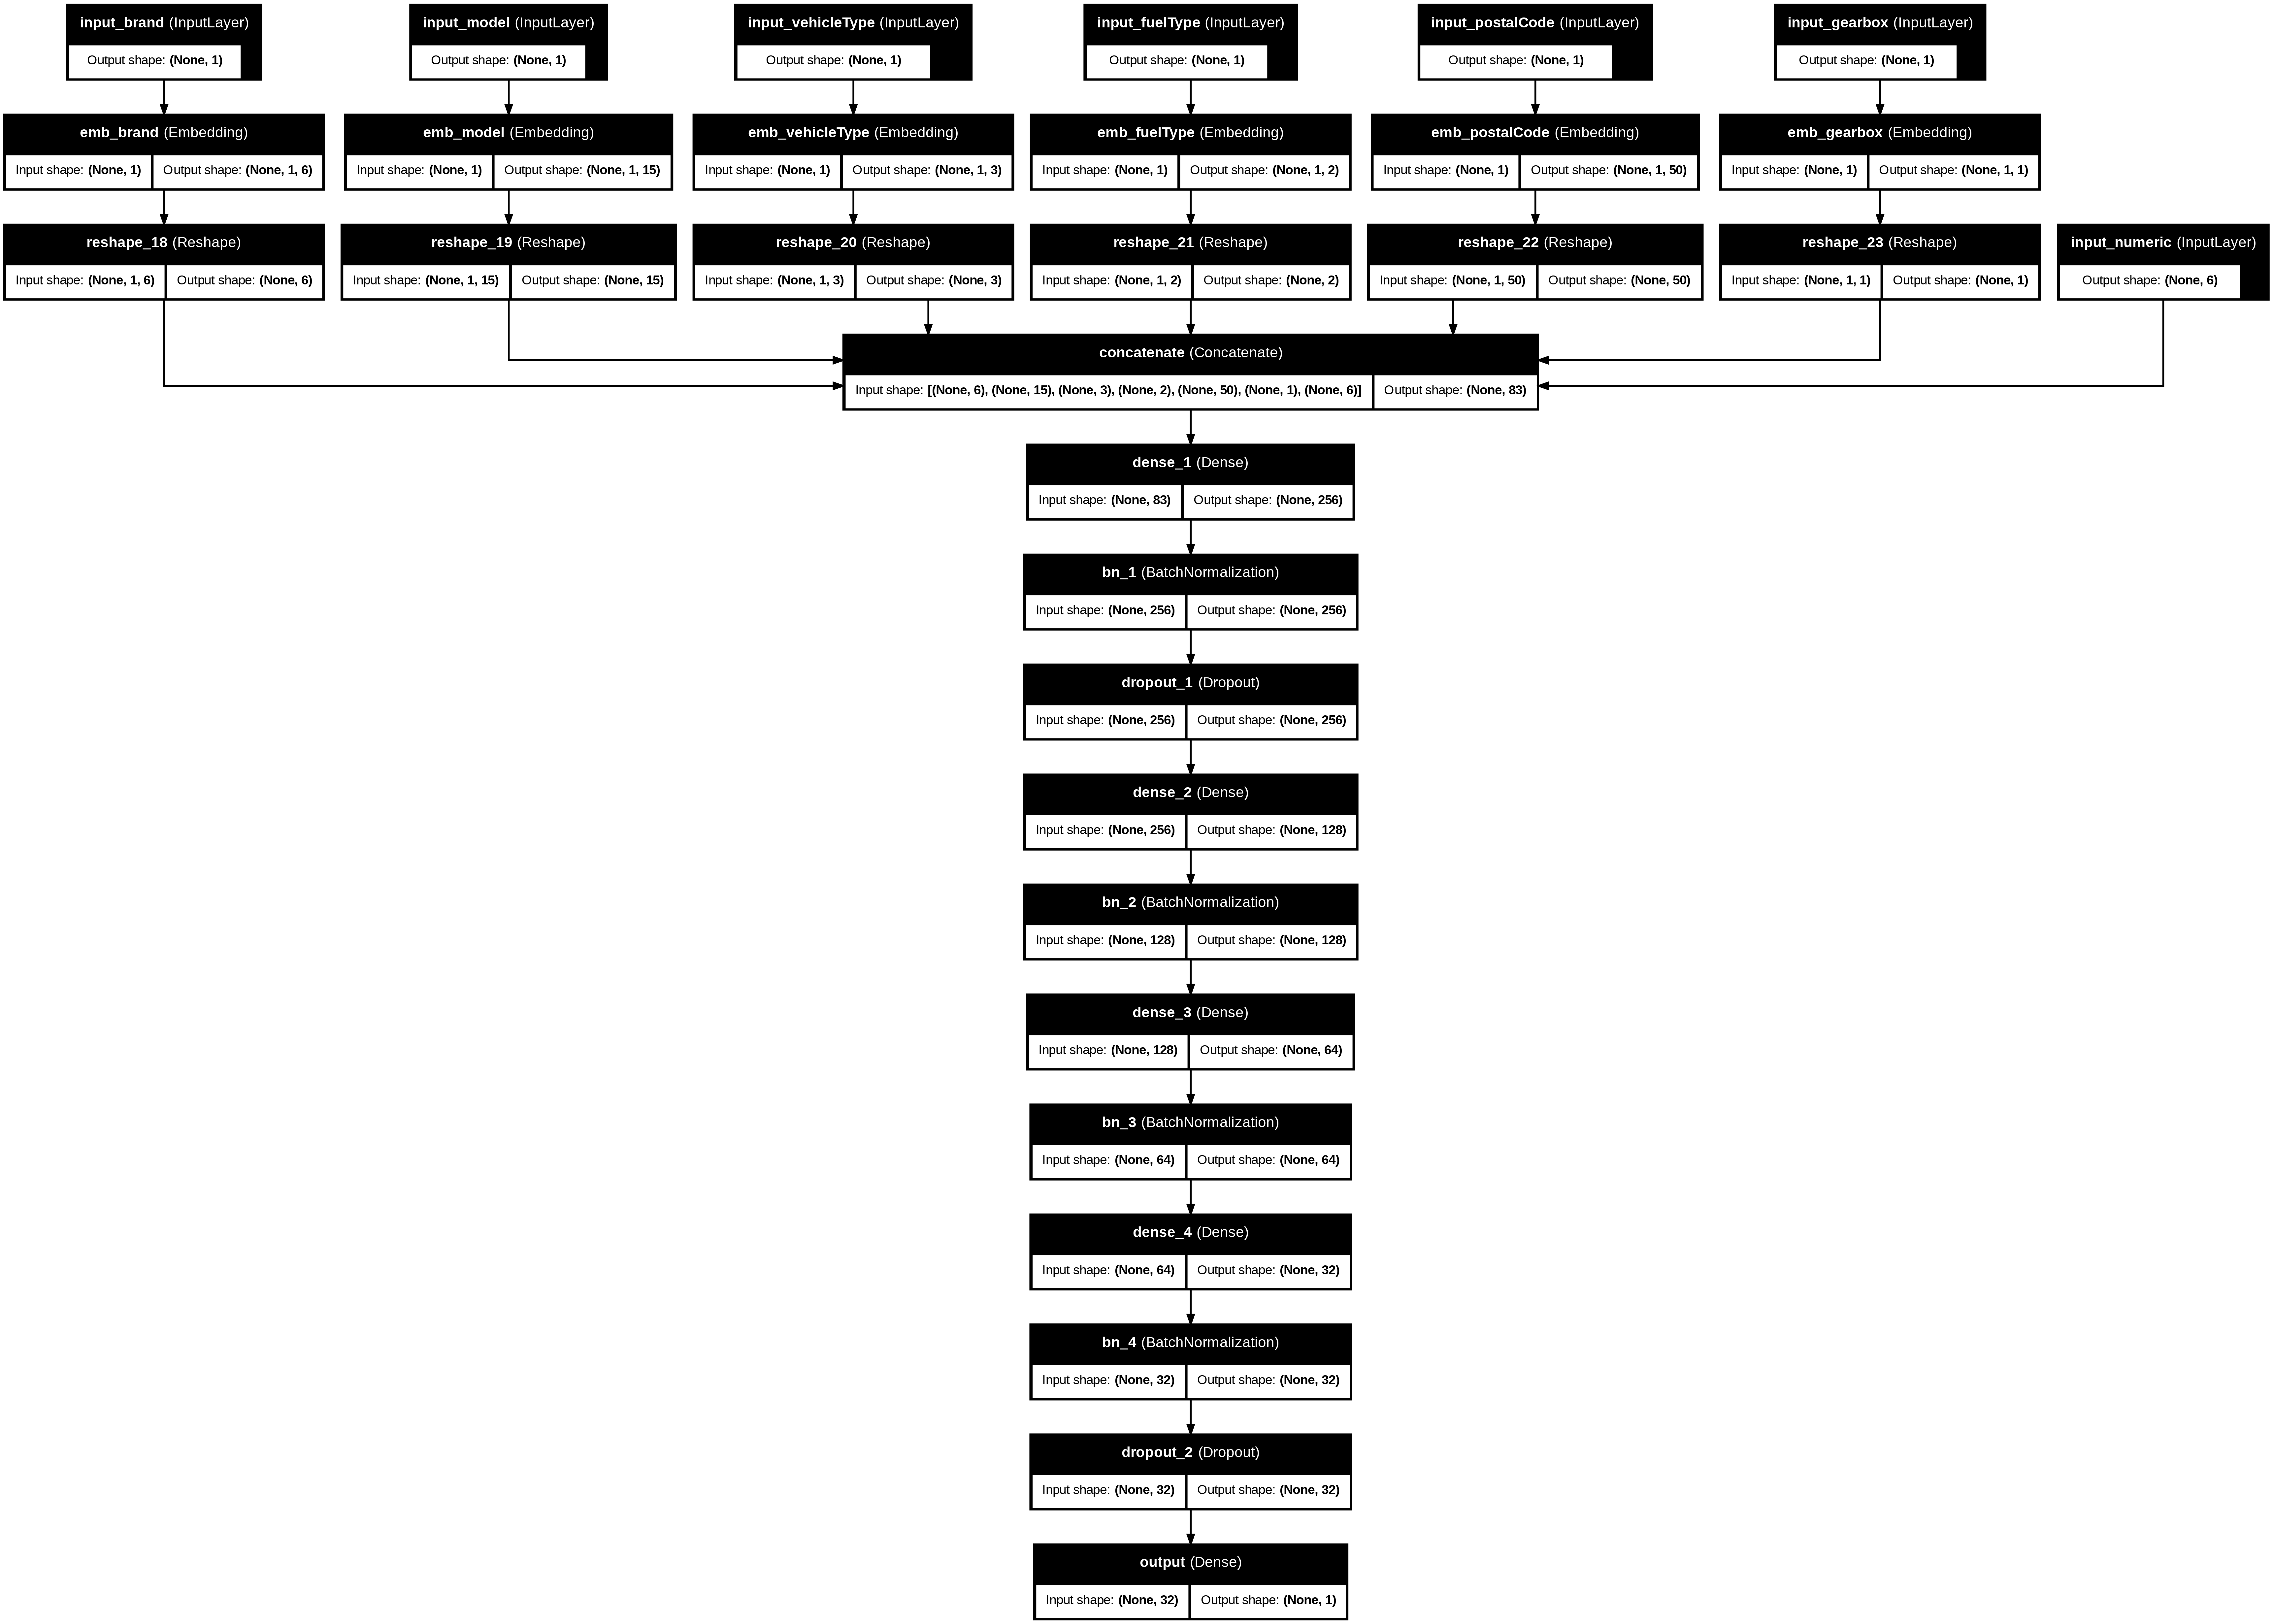

In [50]:
from tensorflow.keras.regularizers import l2

# Regularization parameter
l2_reg = 0.005  # Tăng từ 0.001 lên 0.005

# Define inputs and embedding layers for categorical variables
inputs = []
embeddings = []
for col in categorical_cols:
    input_cat = Input(shape=(1,), name=f'input_{col}')
    emb = Embedding(input_dim=len(np.unique(X_train[col])), output_dim=embedding_dims[col], name=f'emb_{col}')(input_cat)
    emb = Reshape(target_shape=(embedding_dims[col],))(emb)
    inputs.append(input_cat)
    embeddings.append(emb)

# Define input for numerical variables
input_numeric = Input(shape=(len(numerical_cols),), name='input_numeric')
inputs.append(input_numeric)

# Concatenate all embeddings and numerical input
combined = Concatenate(name='concatenate')(embeddings + [input_numeric])

# Build neural network layers with BN and L2 regularization
x = Dense(256, activation='relu', kernel_regularizer=l2(l2_reg), name='dense_1')(combined)  # Tăng từ 128 lên 256
x = BatchNormalization(name='bn_1')(x)
x = Dropout(0.3, name='dropout_1')(x)  # Tăng từ 0.2 lên 0.3
x = Dense(128, activation='relu', kernel_regularizer=l2(l2_reg), name='dense_2')(x)  # Tăng từ 64 lên 128
x = BatchNormalization(name='bn_2')(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(l2_reg), name='dense_3')(x)  # Tăng từ 32 lên 64
x = BatchNormalization(name='bn_3')(x)
x = Dense(32, activation='relu', kernel_regularizer=l2(l2_reg), name='dense_4')(x)  # Thêm lớp mới
x = BatchNormalization(name='bn_4')(x)
x = Dropout(0.3, name='dropout_2')(x)

# Output layer (linear activation for regression)
outputs = Dense(1, activation='linear', name='output')(x)

# Create the model
nn = Model(inputs=inputs, outputs=outputs, name='Enhanced_EE_FNN_Optimized_v5')

# Model summary
print("\nModel summary for the optimized EE model (v5):")
nn.summary()

# Visualize the model architecture
plot_model(nn, show_shapes=True, show_layer_names=True, to_file='Enhanced_EE_FNN_Optimized_v5.png')
Image(retina=True, filename='Enhanced_EE_FNN_Optimized_v5.png')

Cell 7: Make Predictions and Evaluate

Epoch 1/300
902/902 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - loss: 3.9558 - mae: 1.0070 - val_loss: 2.4543 - val_mae: 0.4281 - learning_rate: 1.0000e-04
Epoch 2/300
902/902 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - loss: 2.8274 - mae: 0.7053 - val_loss: 2.1241 - val_mae: 0.3850 - learning_rate: 1.0000e-04
Epoch 3/300
902/902 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 2.2728 - mae: 0.5746 - val_loss: 1.8222 - val_mae: 0.3640 - learning_rate: 1.0000e-04
Epoch 4/300
902/902 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 1.8296 - mae: 0.4839 - val_loss: 1.5317 - val_mae: 0.3548 - learning_rate: 1.0000e-04
Epoch 5/300
902/902 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 1.4386 - mae: 0.4106 - val_loss: 1.2516 - val_mae: 0.3417 - learning_rate: 1.0000e-04
Epoch 6/300
902/902 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 1.1213 - mae: 0.3529 - val_loss: 1.0472 - val_mae: 0.3359 - learning_rate: 1.0000e-04
Epoch 7/300
902/902 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - loss: 0.8639 - mae: 0.3088 - val_loss: 0.8056 - v

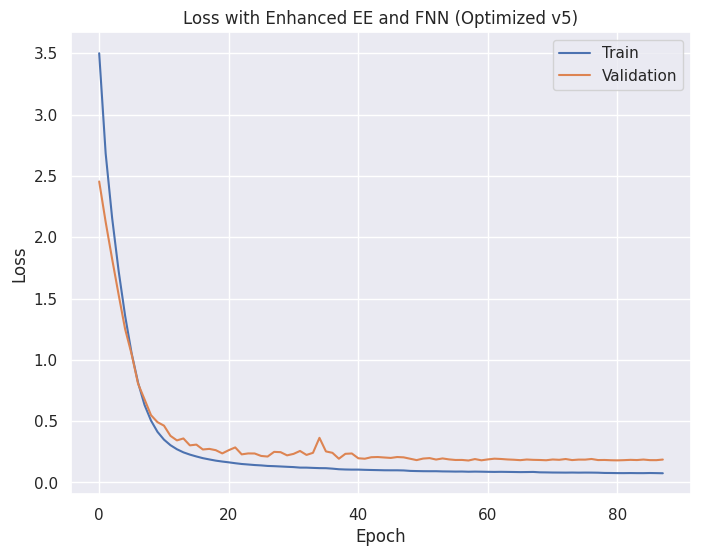

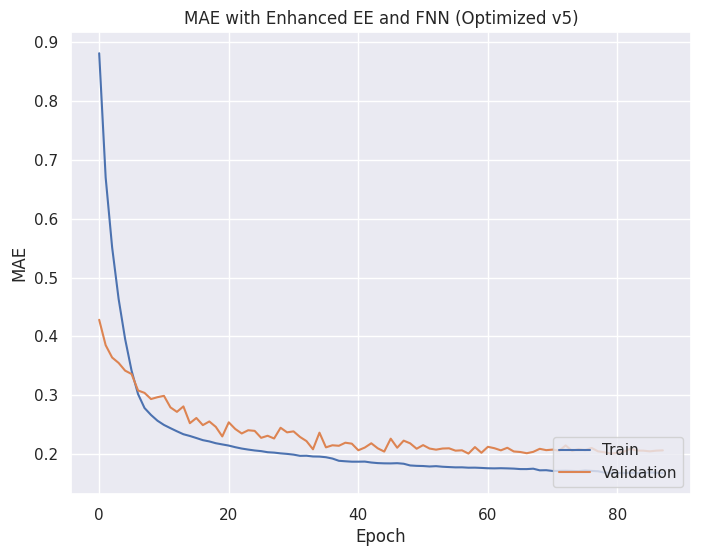

In [51]:
# Compile the model
nn.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.0001), metrics=['mae'])

# Set up early stopping with patience = 30
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30, restore_best_weights=True)

# Set up learning rate scheduler with slower reduction
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=10, min_lr=1e-6, verbose=1)

# Train the model for up to 300 epochs
history = nn.fit(
    input_list_train,
    y_train,
    validation_data=(input_list_val, y_val),
    epochs=300,
    batch_size=256,  # Tăng từ 128 lên 256
    verbose=1,
    callbacks=[es, lr_scheduler]
)

# Plot training & validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss with Enhanced EE and FNN (Optimized v5)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot training & validation MAE
plt.figure(figsize=(8, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE with Enhanced EE and FNN (Optimized v5)')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

Cell 8: Prediction, Evaluation & Residuals Plot

2255/2255 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


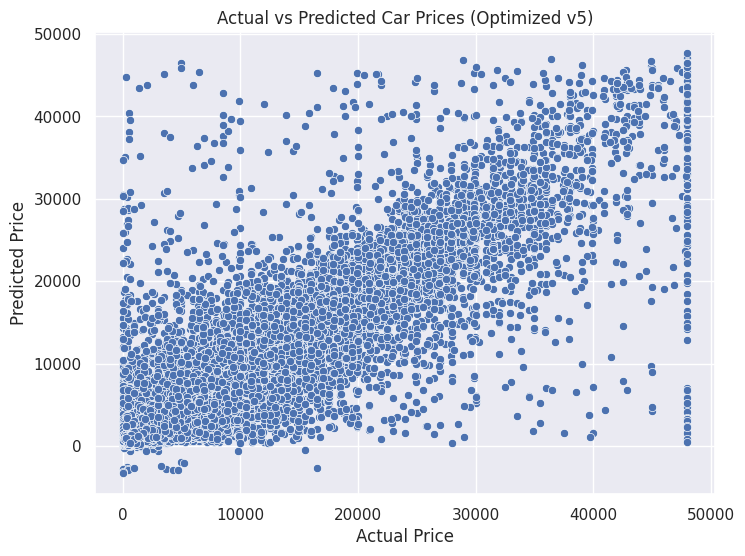

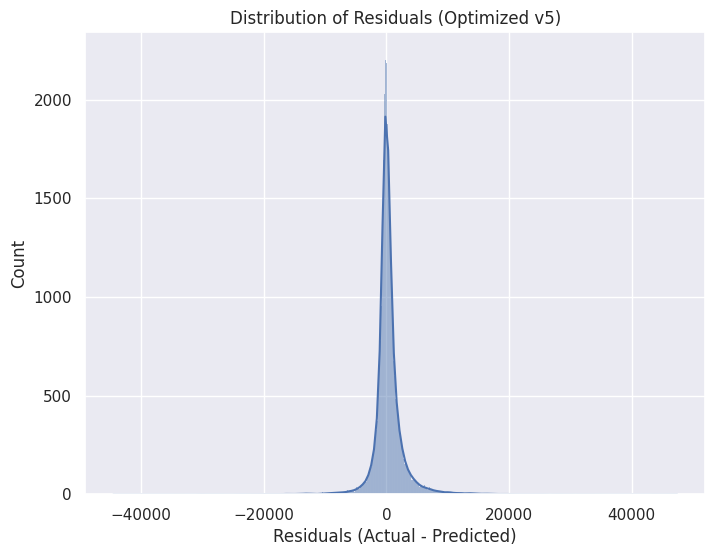


The MSE for the model is 8624179.00
The RMSE for the model is 2936.70.
The MAE for the model is 1428.18.
The R-squared for the model is 0.83.
The MAPE for the model is 0.81.
The SMAPE for the model is 0.36.


In [52]:
# Generate predictions on the test set
y_test_predict = nn.predict(input_list_test)

# Inverse transform predictions and true values to original scale
y_test_predict = price_scaler.inverse_transform(y_test_predict)
y_test = price_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Flatten predictions if necessary
y_test_predict = y_test_predict.flatten()

# Scatter plot: Actual vs. Predicted Prices
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_test_predict)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Car Prices (Optimized v5)')
plt.show()

# Calculate residuals
residuals = y_test - y_test_predict

# Plot histogram of residuals with KDE
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals (Actual - Predicted)')
plt.title('Distribution of Residuals (Optimized v5)')
plt.show()

# Compute evaluation metrics
MSE = np.mean(residuals**2)
RMSE = np.sqrt(MSE)
MAE_val = np.mean(np.abs(residuals))
R2 = 1 - np.sum(residuals**2) / np.sum((y_test - np.mean(y_test))**2)

# Tính MAPE với epsilon để tránh chia cho 0
epsilon = 1e-10
MAPE = np.mean(np.abs(residuals / (y_test + epsilon)))

# Tính SMAPE như một chỉ số thay thế
SMAPE = np.mean(2 * np.abs(residuals) / (np.abs(y_test) + np.abs(y_test_predict)))

print(f'\nThe MSE for the model is {MSE:.2f}')
print(f'The RMSE for the model is {RMSE:.2f}.')
print(f'The MAE for the model is {MAE_val:.2f}.')
print(f'The R-squared for the model is {R2:.2f}.')
print(f'The MAPE for the model is {MAPE:.2f}.')
print(f'The SMAPE for the model is {SMAPE:.2f}.')

# MLP Training